# Semantic Segmentation with on the fly Data Augmentation


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from gm_networks import unet_model
from utils import center_crop, normalize_data, create_dataset_from_one_image

In [ ]:
# Load the initial input and output images 
x_initial_train = plt.imread('train/101-INPUT.jpg')
y_initial_train = plt.imread('train/101-OUTPUT-GT.png')

In [ ]:
# Model/training hyperparameters
INPUT_SHAPE = (512, 512, 3)
INITIAL_FILTERS = 32
PADDING = 'same'

TRAIN_IMAGES_NUMBER = 5

BATCH_SIZE = 8
EPOCHS = 50
steps_per_epoch = TRAIN_IMAGES_NUMBER // BATCH_SIZE# Define the new size to create images of size (NEW_SIZE, NEW_SIZE), as well as define the number of train and validation images to be created

In [ ]:
model = unet_model(input_shape=INPUT_SHAPE, initial_filters=INITIAL_FILTERS, padding=PADDING)

In [7]:
x_train, y_train = create_dataset_from_one_image(x_initial_train, y_initial_train, 512, mode='independent_patches', new_images_number = 150, patches_step=-512)

In [8]:
# Create dictionaries with the alterations to be used for the data augmentation operations for inputs and outputs
""""
NOTE: It is important to use exact the same values for the parameters in both dictionaries. 
The reason why we create 2 dictionaries instead of a common one is because  we want to add the 
preprocessing function for the output masks (this function sets all the pixel values of the mask to 0 or 1. 
While the initial ground truth images are binary, after the data augmentation operations, such as rotations and 
shifts, pixels with intermediate values are appeared due to interpolation)
"""
x_datagen_args = dict(
    rotation_range=25, 
    width_shift_range=0.1, 
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
    preprocessing_function = lambda x: normalize_data(x)) #TODO: Check why it creates nan values

y_datagen_args = dict(
    rotation_range=25, 
    width_shift_range=0.1, 
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect', 
    preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))

In [9]:
# Instatiate the generators
x_datagen = ImageDataGenerator(**x_datagen_args)
y_datagen = ImageDataGenerator(**y_datagen_args)

# Setting the same seed number for both generators leads to the same random alterations for both generators
seed = 19
x_datagen.fit(x_train, augment=True, seed=seed)
y_datagen.fit(y_train, augment=True, seed=seed)

x_generator_train = x_datagen.flow(x_train, seed=seed, batch_size=BATCH_SIZE)
y_generator_train = y_datagen.flow(y_train, seed=seed, batch_size=BATCH_SIZE)

train_generator = zip(x_generator_train, y_generator_train)

In [69]:
a = x_generator_train.next()
print(a.max())


nan


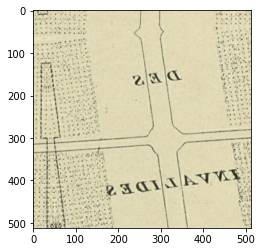

In [70]:
plt.imshow(a[0])
plt.show()

In [ ]:
# Define the model and train
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS)

In [ ]:
# save the model and history of the training (loss, accuracy)
model_path = f'models/Unet_inputsize{new_size}_initialfilters{INITIAL_FILTERS}_padding_{PADDING}_epochs{EPOCHS}' #TODO: loss and metric'
model.save(model_path)


In [ ]:
np.save(os.path.join(model_path, 'history'), history.history)